##  EDA Part 2

Now we will continue where we left off

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.offline as pyoff

In [19]:
# Read df_revenue.csv into a DataFrame
df_revenue = pd.read_csv('df_revenue.csv')

# Read df.csv into a DataFrame
df = pd.read_csv('df.csv')

### Monthly Active Customers

Now we will look at the monthly active customers, the same way we processed Monthly revenue. For now we will look at UK customers only

In [20]:
#creating a new dataframe with UK customers only
df_uk = df.query("Country=='United Kingdom'").reset_index(drop=True)

#creating monthly active customers dataframe by counting unique Customer IDs
df_monthly_active = df_uk.groupby('YearMonth')['CustomerID'].nunique().reset_index()


#plotting the output
plot_data = [
    go.Bar(
        x=df_monthly_active['YearMonth'],
        y=df_monthly_active['CustomerID'],
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='Monthly Active Customers'
    )

fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

Now, does the trend we observe here extend to the number of orders as well ? let's check.

In [21]:

#create a new dataframe for no. of order by using quantity field
df_monthly_sales = df_uk.groupby('YearMonth')['Quantity'].sum().reset_index()

# #print the dataframe
# df_monthly_sales

#plot
plot_data = [
    go.Bar(
        x=df_monthly_sales['YearMonth'],
        y=df_monthly_sales['Quantity'],
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='Monthly Total # of Order'
    )

fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

Now let's go deeper and look at other important metrics, we will start with New Customer Ratio, but first what defines a new customer ?

We can assume a new customer is whoever did his/her first purchase in the time window we defined. We will do it monthly for this example.



### New Customer Ratio

Note: This cell contains a merge operationa and should be run only once.

In [22]:
#create a dataframe contaning CustomerID and first purchase date
df_min_purchase = df_uk.groupby('CustomerID').InvoiceDate.min().reset_index()
df_min_purchase.columns = ['CustomerID','MinPurchaseDate']
# Assuming df_min_purchase is your DataFrame
df_min_purchase['MinPurchaseDate'] = pd.to_datetime(df_min_purchase['MinPurchaseDate'], format='%Y-%m-%d %H:%M:%S')
df_min_purchase['MinPurchaseYearMonth'] = df_min_purchase['MinPurchaseDate'].dt.to_period('M').astype(str)


#merge first purchase date column to our main dataframe (df_uk)
df_uk = pd.merge(df_uk, df_min_purchase, on='CustomerID')

#if User's First Purchase Year Month before the selected Invoice Year Month
df_uk['UserType'] = 'New'
df_uk.loc[df_uk['YearMonth']>df_uk['MinPurchaseYearMonth'],'UserType'] = 'Existing'

#calculate the Revenue per month for each user type
df_user_type_revenue = df_uk.groupby(['YearMonth','UserType'])['Revenue'].sum().reset_index()

#filtering the dates and plot the result
df_user_type_revenue = df_user_type_revenue.query("YearMonth != '2010-12' and YearMonth != '2011-12'")
plot_data = [
    go.Scatter(
        x=df_user_type_revenue.query("UserType == 'Existing'")['YearMonth'],
        y=df_user_type_revenue.query("UserType == 'Existing'")['Revenue'],
        name = 'Existing'
    ),
    go.Scatter(
        x=df_user_type_revenue.query("UserType == 'New'")['YearMonth'],
        y=df_user_type_revenue.query("UserType == 'New'")['Revenue'],
        name = 'New'
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='New vs Existing'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

Existing customers are showing a positive trend and tell us that our customer base is growing but new customers have a slight negative trend.

### Monthly Retention Rate

It is crucial to closely monitor the retention rate as it serves as an indicator of the stickiness of your service and the compatibility of your product with the market. To create a visual representation of the Monthly Retention Rate, it is essential to calculate the number of customers retained from the previous month.

In [23]:
## Monthly Retention Rate

#identify which users are active by looking at their revenue per month
df_user_purchase = df_uk.groupby(['CustomerID','YearMonth'])['Revenue'].sum().reset_index()

#create retention matrix with crosstab
df_retention = pd.crosstab(df_user_purchase['CustomerID'], df_user_purchase['YearMonth']).reset_index()

df_retention.head()

#create an array of dictionary which keeps Retained & Total User count for each month
months = df_retention.columns[2:]
retention_array = []
for i in range(len(months)-1):
    retention_data = {}
    selected_month = months[i+1]
    prev_month = months[i]
    retention_data['YearMonth'] = selected_month #int(selected_month)
    retention_data['TotalUserCount'] = df_retention[selected_month].sum()
    retention_data['RetainedUserCount'] = df_retention[(df_retention[selected_month]>0) & (df_retention[prev_month]>0)][selected_month].sum()
    retention_array.append(retention_data)
    
#convert the array to dataframe and calculate Retention Rate
df_retention = pd.DataFrame(retention_array)
df_retention['RetentionRate'] = df_retention['RetainedUserCount']/df_retention['TotalUserCount']

#plot the retention rate graph
plot_data = [
    go.Scatter(
        x=df_retention.query("YearMonth != '2011-12'")['YearMonth'],
        y=df_retention.query("YearMonth != '2011-12'")['RetentionRate'],
        name="organic"
    )
    
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='Monthly Retention Rate'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

    

### Cohort Based Retention Rate

An alternative method for assessing Retention Rate enables you to examine the retention rate for individual cohorts. Cohorts are identified based on the customers' first purchase year-month. We will assess the percentage of customers retained after their initial purchase each month. This perspective allows us to compare the retention rates between recent and older cohorts, providing insights into any differences and determining if recent alterations in customer experience impact the retention of new customers.



In [75]:
df_user_purchase = df_user_purchase[df_user_purchase['YearMonth'] != '2011-12']

months = months[months != '2011-12']


In [77]:

#create our retention table again with crosstab() and add firs purchase year month view
df_retention = pd.crosstab(df_user_purchase['CustomerID'], df_user_purchase['YearMonth']).reset_index()
df_retention = pd.merge(df_retention,df_min_purchase[['CustomerID','MinPurchaseYearMonth']],on='CustomerID')
new_column_names = [ 'm_' + str(column) for column in df_retention.columns[:-1]]
new_column_names.append('MinPurchaseYearMonth')
df_retention.columns = new_column_names

#create the array of Retained users for each cohort monthly
retention_array = []
for i in range(len(months)):
    retention_data = {}
    selected_month = months[i]
    prev_months = months[:i]
    next_months = months[i+1:]
    for prev_month in prev_months:
        retention_data[prev_month] = np.nan
        
    total_user_count = df_retention[df_retention.MinPurchaseYearMonth ==  selected_month].MinPurchaseYearMonth.count()
    retention_data['TotalUserCount'] = total_user_count
    retention_data[selected_month] = 1 
    

    query = "`MinPurchaseYearMonth` == '{}'".format(months[0])

    

    for next_month in next_months:
        new_query = query + " and {} > 0".format("`"+str('m_' + str(months[1])+ "`"))
        retention_data[next_month] = np.round(df_retention.query(new_query)['m_' + str(next_month)].sum()/total_user_count,2)
    retention_array.append(retention_data)
    
df_retention = pd.DataFrame(retention_array)
df_retention.index = months

## get cohort_size
cohort_size = df_retention.iloc[:, 0]
df_retention = df_retention.drop('TotalUserCount', axis=1)
#showing new cohort based retention table
df_retention

,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11
YearMonth,,,,,,,,,,,
2011-01,1.0,0.23,0.10,0.11,0.14,0.13,0.10,0.08,0.12,0.11,0.12
2011-02,NaN,1.00,0.11,0.12,0.15,0.14,0.11,0.09,0.13,0.12,0.13
2011-03,NaN,NaN,1.00,0.10,0.12,0.11,0.09,0.07,0.11,0.10,0.11
2011-04,NaN,NaN,NaN,1.00,0.18,0.17,0.13,0.11,0.16,0.15,0.16
2011-05,NaN,NaN,NaN,NaN,1.00,0.18,0.14,0.12,0.17,0.16,0.18
2011-06,NaN,NaN,NaN,NaN,NaN,1.00,0.17,0.14,0.21,0.20,0.22
2011-07,NaN,NaN,NaN,NaN,NaN,NaN,1.00,0.17,0.26,0.24,0.26
2011-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00,0.31,0.29,0.32
2011-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00,0.15,0.16


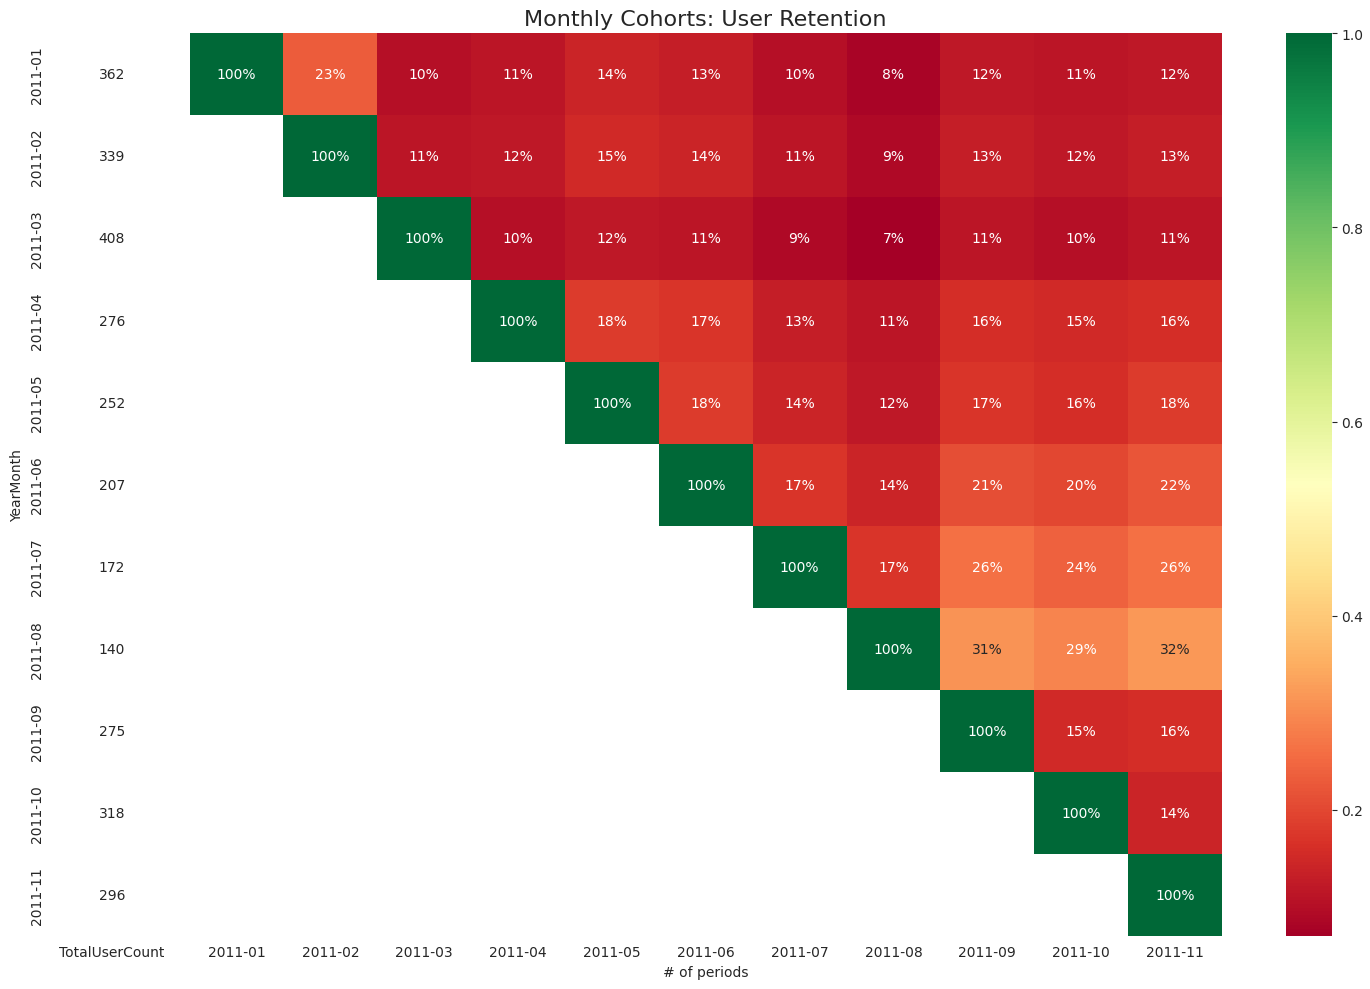

In [78]:
import seaborn as sns
import matplotlib.colors as mcolors


with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(15, 10), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(df_retention, 
                mask=df_retention.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', 
                ax=ax[1])
    ax[1].set_title('Monthly Cohorts: User Retention', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()